In [1]:
from IPython.display import clear_output

In [2]:
# Download the required libraries (needed when running outside colab where the environment doesn't come pre-loaded with libraries)

%pip install torch
%pip install torchvision
%pip install matplotlib

clear_output()

In [3]:
import torch
from torchvision import models,transforms
import torch.nn as nn

from torchvision.datasets import CIFAR10
from torchvision.transforms.functional import to_tensor, to_pil_image, resize

from torch.utils.data import DataLoader
from torch.optim import Adam

import matplotlib.pyplot as plt

#Contents:

1. We'll make a classifier for CIFAR10 dataset in pytorch using CNN architecture

About CIFAR10:

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

![CIFAR-10 image](https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png)


You need to know:

1. **torch** (for impelementation)
2. a little bit of **matplotlib** (for visualization)


Good to have knowledge of:

1. torch dataset and dataloader

# Downloading the dataset

In [4]:
dataset_root = 'data/'

train_dataset = CIFAR10(root=dataset_root, train=True, download=True, transform=to_tensor)
val_dataset = CIFAR10(root=dataset_root, train=False, download=True, transform=to_tensor)

100%|██████████| 170498071/170498071 [00:03<00:00, 46469374.85it/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [5]:
print('Length of train_dataset is', len(train_dataset))
print('Length of val_dataset is'  , len(val_dataset))

Length of train_dataset is 50000
Length of val_dataset is 10000


In [6]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # no need to shuffle validation data

## Let's visualize the images and it's channels

torch.Size([3, 250, 250])
Number of channels in test_image:  3


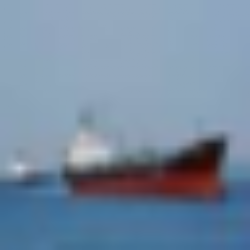

In [7]:
random_img_idx = torch.randint(0, 1000, (1,)).item()

test_image = train_dataset[random_img_idx][0]  # 0 for image part in (image, label) tuple.
test_image = resize(test_image, (250, 250), antialias=None)  # better visualization
print(test_image.shape)
print('Number of channels in test_image: ', test_image.shape[0])
to_pil_image(test_image)

In [8]:
tred, tgreen, tblue = test_image
empty_channel = torch.zeros_like(tred)

tred = [tred, empty_channel, empty_channel]  #R00
tgreen = [empty_channel, tgreen, empty_channel]  #0G0
tblue = [empty_channel, empty_channel, tblue]  #00B

channels = [torch.stack(img) for img in [tred, tgreen, tblue]]

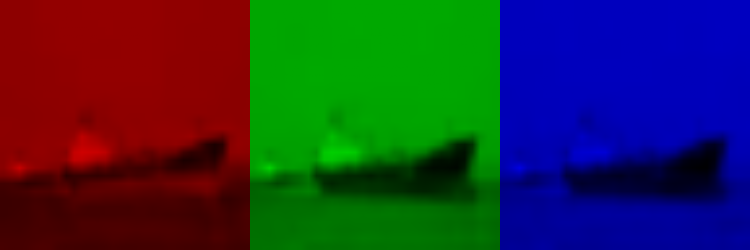

In [9]:
to_pil_image(torch.cat(channels, dim=2))

In [10]:
class Cifar10Classifier(nn.Module):

  def __init__(self):

    super(Cifar10Classifier, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

    self.relu = nn.ReLU()  # Relu isn't learnable. no need to intialize different relu objects for each layer
    self.pool = nn.MaxPool2d(2, 2)  # pool isn't learnable to no need to initialize different pool layers unless we want to change window size

    self.fc1 = nn.Linear(128 * 4 * 4, 512)
    self.fc2 = nn.Linear(512, 10)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x: torch.Tensor):

    single_input = False
    if x.ndim == 3:  # 3 dimensions mean [C, H, W] instead of [B, C, H, W] so we're dealing with a single image
      x = x.unsqueeze(dim=0)  # convert [C, H, W] to [1, C, H, W] where 1 will act as batch size

      # keep track of whether input was one (non-batch) image.
      # If so, we want to convert it back to the same format after inference for consistency purposes
      single_input = True

    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = self.pool(self.relu(self.conv3(x)))
    x = x.flatten(start_dim=1)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    x = self.softmax(x)

    if single_input:
      x = x.squeeze(dim=0)  # or x = x[0]

    return x


In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # checks if machine supports cuda and if it does, we use that, otherwise cpu
model = Cifar10Classifier().to(device)

In [12]:
num_epochs = 30
lr = 1e-4

train_losses = []
val_losses = []

optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()  # multi-class

model.to(device)

print(f'Using device {device}')

Using device cuda


In [13]:
%%time
for epoch_no in range(num_epochs):

  model.train()  # convert to train model. This turns out train-specific layers in the model (if you dont know about them, an example of them is dropout. more on this later)

  epoch_weighted_loss = 0

  for batch_X, batch_y in train_loader:

    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)

    batch_y_probs = model(batch_X)  # outputs [N, 10] where each [:, 10] is probabilities for class (0-9)

    loss = criterion(batch_y_probs, batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_weighted_loss += (len(batch_y)*loss.item())

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
  train_losses.append(epoch_loss)


  # validation time

  model.eval()  # take model to evaluation mode. turn off train-only layers
  correctly_labelled = 0

  with torch.no_grad():

    val_epoch_weighted_loss = 0

    for val_batch_X, val_batch_y in val_loader:

      val_batch_X = val_batch_X.to(device)
      val_batch_y = val_batch_y.to(device)

      val_batch_y_probs = model(val_batch_X)

      loss = criterion(val_batch_y_probs, val_batch_y)
      val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

      val_batch_y_pred = val_batch_y_probs.argmax(dim=1)  # convert probailities to labels by picking the label (index) with the highest prob

      correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()  # item converts tensor to float/int/list

  val_epoch_loss = val_epoch_weighted_loss/len(val_loader.dataset)
  val_losses.append(val_epoch_loss)

  print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(val_loader.dataset)} correctly ({correctly_labelled/len(val_loader.dataset)*100}% accuracy)')

print(f'Training complete on device {device}.')

Epoch: 0, train_loss=2.166326034164429, val_loss=2.0800704452514647. labelled 3851/10000 correctly (38.51% accuracy)
Epoch: 1, train_loss=2.0683755322647093, val_loss=2.0416098724365233. labelled 4186/10000 correctly (41.86% accuracy)
Epoch: 2, train_loss=2.0344847763824463, val_loss=2.0258125663757323. labelled 4313/10000 correctly (43.13% accuracy)
Epoch: 3, train_loss=2.012515848464966, val_loss=2.004808918762207. labelled 4578/10000 correctly (45.78% accuracy)
Epoch: 4, train_loss=1.9954395385742187, val_loss=1.9826433673858643. labelled 4789/10000 correctly (47.89% accuracy)
Epoch: 5, train_loss=1.977848351211548, val_loss=1.981432685661316. labelled 4800/10000 correctly (48.0% accuracy)
Epoch: 6, train_loss=1.9610294099426269, val_loss=1.9542925704956056. labelled 5086/10000 correctly (50.86000000000001% accuracy)
Epoch: 7, train_loss=1.9447229447174073, val_loss=1.9381942441940307. labelled 5252/10000 correctly (52.52% accuracy)
Epoch: 8, train_loss=1.9295476302719117, val_loss=

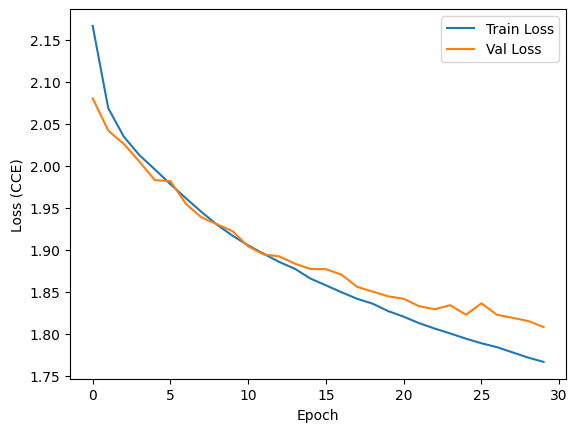

In [14]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses  , label='Val Loss')

plt.ylabel('Loss (CCE)')
plt.xlabel('Epoch')

plt.legend()
plt.show()

## Exploring the Power of Transfer Learning

In [15]:
# get the resnet pretrained model
net = models.resnet18(pretrained =True)
# freeze all layers
for params in net.parameters():
  params.requires_grad = False
# unfreeze the FC layers
net.fc = nn.Linear(in_features=512, out_features=10, bias=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 83.8MB/s]


In [16]:
# check that all the layers are frozen except the last 2 layers
for params in net.parameters():
  print(params.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


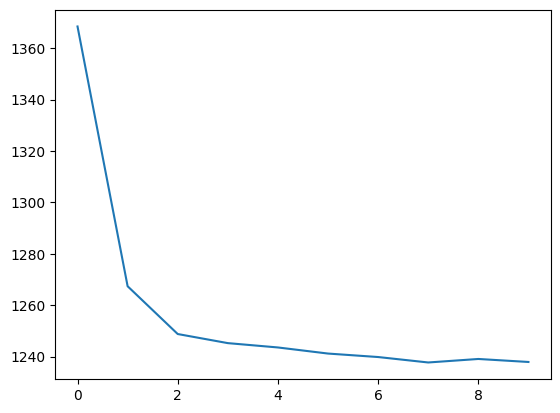

In [17]:
# train the FC layers on the dataset (the unfrozen layers)
device = torch.device('cuda:0')
net = net.to(device)
num_epochs = 10
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=lr)
ls = []

for _ in range(num_epochs):
  total_loss = 0  # zero out the loss each iteration
  for batch in train_loader:
    X, y = batch[0].to(device), batch[1].to(device)
    logits = net(X)
    loss = criterion(logits, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  # bookkeep the
  ls.append(total_loss)

# plot the loss curve
plt.plot(ls)

In [18]:
# unfreeze the remaining layers
for params in net.parameters():
  params.requires_grad = True

In [20]:
num_epochs = 30
lr = 1e-4

train_losses = []
val_losses = []

optimizer = Adam(net.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()  # multi-class

In [21]:
# train the full model

%%time
for epoch_no in range(num_epochs):

  net.train()

  epoch_weighted_loss = 0

  for batch_X, batch_y in train_loader:

    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)

    batch_y_probs = net(batch_X)

    loss = criterion(batch_y_probs, batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_weighted_loss += (len(batch_y)*loss.item())

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
  train_losses.append(epoch_loss)




  net.eval()
  correctly_labelled = 0

  with torch.no_grad():

    val_epoch_weighted_loss = 0

    for val_batch_X, val_batch_y in val_loader:

      val_batch_X = val_batch_X.to(device)
      val_batch_y = val_batch_y.to(device)

      val_batch_y_probs = net(val_batch_X)

      loss = criterion(val_batch_y_probs, val_batch_y)
      val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

      val_batch_y_pred = val_batch_y_probs.argmax(dim=1)

      correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()

  val_epoch_loss = val_epoch_weighted_loss/len(val_loader.dataset)
  val_losses.append(val_epoch_loss)

  print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(val_loader.dataset)} correctly ({correctly_labelled/len(val_loader.dataset)*100}% accuracy)')

print(f'Training complete on device {device}.')

Epoch: 0, train_loss=0.9939900701904297, val_loss=0.7318056715011597. labelled 7433/10000 correctly (74.33% accuracy)
Epoch: 1, train_loss=0.6187156357574463, val_loss=0.6304996941566468. labelled 7834/10000 correctly (78.34% accuracy)
Epoch: 2, train_loss=0.4576834646034241, val_loss=0.6153025178909302. labelled 7935/10000 correctly (79.35% accuracy)
Epoch: 3, train_loss=0.33718695317745206, val_loss=0.6290618749618531. labelled 7966/10000 correctly (79.66% accuracy)
Epoch: 4, train_loss=0.2502636142683029, val_loss=0.6697354173660278. labelled 8069/10000 correctly (80.69% accuracy)
Epoch: 5, train_loss=0.1920368017101288, val_loss=0.6944967222213745. labelled 8006/10000 correctly (80.06% accuracy)
Epoch: 6, train_loss=0.1533237656545639, val_loss=0.7317294791221619. labelled 8109/10000 correctly (81.08999999999999% accuracy)
Epoch: 7, train_loss=0.12732689028978347, val_loss=0.7692788689613342. labelled 8114/10000 correctly (81.14% accuracy)
Epoch: 8, train_loss=0.11018628450512886, 

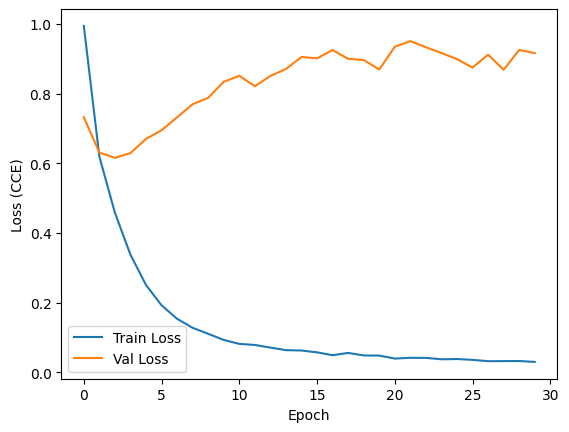

In [22]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses  , label='Val Loss')

plt.ylabel('Loss (CCE)')
plt.xlabel('Epoch')

plt.legend()
plt.show()